# Week 4 Mini Project: Natural Language Processing with Disaster Tweets

The purpose of this project is to utilize Natural Language Processing to aid in monitoring Twitter tweets as a source of news regarding announcement of a disaster. We are tasked with building a model that predicts which tweets are about actual disasters versus not. The dataset consists of 10,000 tweets that were previously classified. Natural language processing is using a computers ability to automate going through a plethora of data in order to support and manipulate human language.

This data is taken from a [kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview) which evaluates test submissions by F1 metrics.

Data files and saved models can be found in the following [GitHub Repo](https://github.com/ancr8790/DisasterTweets/tree/main)

### Import Necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#changing directory to access files. Edit as necessary for your system
import os
os.chdir("drive/MyDrive/Intro to Deep Learning/Week 4")
os.listdir()

Mounted at /content/drive


['nlp-getting-started',
 'model1',
 'model2',
 'model3',
 'model4',
 'model5',
 'Model2_submission.csv',
 'Model4_submission.csv',
 'Model5_submission.csv',
 'Model3_submission.csv',
 'model6',
 'Model6_submission.csv',
 'Week4_DisasterNLP.ipynb']

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
#!pip install --upgrade keras-nlp

#import keras_nlp
from keras.models import Sequential
from keras.layers import Dense, TextVectorization, Embedding, Dropout
from keras.regularizers import l2

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import nltk
import string
import re
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
AUTOTUNE = tf.data.AUTOTUNE

print("TensorFlow version:", tf.__version__)
#print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.15.0


In [3]:
# Detect hardware and light up the GPUs/TPUs
#code implemented from https://www.kaggle.com/code/toddgardiner/binary-cancer-classifier
try:
     # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

    # instantiate a distribution strategy
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)

    # tell us what happened
    print('Running on TPU ', tpu.cluster_spec().as_dict())

except ValueError: # If TPU not found
    tpu = None
    tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
    print('Running on CPU instead')

print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)
print("TPU: ", tpu)

Running on CPU instead
Number of accelerators:  1
TPU:  None


In [4]:
#check current directory, change if necessary
parent_path = "/content/drive/MyDrive/Intro to Deep Learning/Week 4"
train_path = "/content/drive/MyDrive/Intro to Deep Learning/Week 4/nlp-getting-started/train.csv"
test_path = "/content/drive/MyDrive/Intro to Deep Learning/Week 4/nlp-getting-started/test.csv"

os.chdir(parent_path)
print(os.getcwd())

/content/drive/MyDrive/Intro to Deep Learning/Week 4


## Import Data

In [5]:
#import training and testing data
dis_train = pd.read_csv(train_path)
dis_test = pd.read_csv(test_path)
sample_sub = pd.read_csv("/content/drive/MyDrive/Intro to Deep Learning/Week 4/nlp-getting-started/sample_submission.csv")

print("Training data")
display(dis_train.head(5))
print("Testing data")
display(dis_test.head(5))

Training data


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Testing data


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print("rows, columns of Train csv file:", dis_train.shape)
print("unique label values:", dis_train['target'].unique())
print("Training data null values:\n", dis_train.isna().sum())

print("\nrows, columns of Test csv file:", dis_test.shape)
print("rows, columns of Sample submission csv file:", sample_sub.shape)
print("Testing data null values:\n", dis_test.isna().sum())


rows, columns of Train csv file: (7613, 5)
unique label values: [1 0]
Training data null values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

rows, columns of Test csv file: (3263, 4)
rows, columns of Sample submission csv file: (3263, 2)
Testing data null values:
 id             0
keyword       26
location    1105
text           0
dtype: int64


After pulling in the data we can see the Training and Testing are identical in structure for the first 3 columns:
1. 'id' is the unique identifier of each tweet
2. 'keyword' is a column that could contain keywords to categorize the tweet.
3. 'location' is a column that contains the location the tweet was sent from.  
4. 'text' is a column that contains the tweet content.
5. 'target' (only in training data) numeric value [0,1] being used as a binary classifier to represent [not about disaster, about a disaster]

## EDA

In [7]:
print(round(dis_train.location.isna().sum()/dis_train.shape[0],2)*100,"% of training data has no location")
print(round(dis_train.keyword.isna().sum()/dis_train.shape[0],2)*100,"% of training data has no keyword")

print(round(dis_test.location.isna().sum()/dis_test.shape[0],2)*100,"% of test data has no location")
print(round(dis_test.keyword.isna().sum()/dis_test.shape[0],2)*100,"% of test data has no keyword")

33.0 % of training data has no location
1.0 % of training data has no keyword
34.0 % of test data has no location
1.0 % of test data has no keyword


In [8]:
dis_train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

The training data has 7,613 observations and the testing data has 3,263 observations.

There are a number of null values for location and keywords. Roughly 33% of both the training and testing data doesn't have location data. In the future this column could be useful once we have a suitable model to determine where disaster are occuring but for the purpose of building the model, it's not really useful. Additionally, 1% of both the training and testing data doesn't have keyword data. Similarly, for the future, once a binary model is built out to determine whether a tweet is describing a disaster or not, another model could be used to categorize the tweet based on type of disaster. In that case, this column would be useful.

However, for this purpose of this project we will focus on the 'text' column and drop the 'location' and 'keyword' column from both the training and testing data.

In [9]:
dis_train = dis_train.drop(['keyword','location'], axis = 1)
dis_test = dis_test.drop(['keyword','location'], axis = 1)
#confirm columns were dropped
display(dis_train.head(), dis_test.head())

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
#determine distribution of target variable
temp_df = pd.DataFrame()
temp_df['Class'] = np.where(dis_train['target'] == 0, "Nondisaster", "Disaster")
class_df = temp_df['Class'].value_counts().rename_axis('Class').reset_index(name = 'count')
class_df['Distribution'] = class_df['count']/sum(class_df['count'])
print(class_df)

         Class  count  Distribution
0  Nondisaster   4342       0.57034
1     Disaster   3271       0.42966


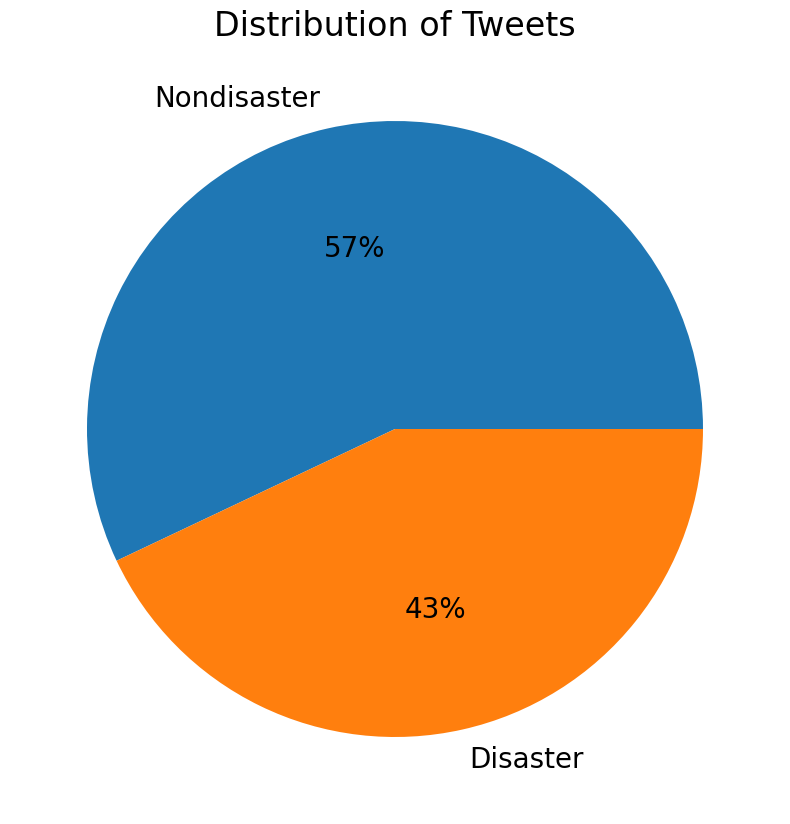

In [11]:
fig,ax = plt.subplots(figsize = (10,10))
plt.rc('font', size=20)
plt.pie(class_df['count'], labels = class_df['Class'], autopct = '%1.0f%%')
plt.title("Distribution of Tweets")
plt.show()

The distribution of this data is relatively even, leaning ever so slightly in favor of the nondisasterous tweets. Given the small magnitude of the majority, we will proceed training with the given distribution.

Based on this EDA, we have made the following observations:

* We are working with 7,613 training observations
* We need to make predictions for 3,263 testing observations
* We confirmed the testing observation csv is the same length as the sample_submission file so all observations needed for the competition submission are accounted for.
* The training dataset has a realtively even distribution with a very slight skew towards nondisasterous tweets (57/43)
* We need to split the Training Dataset into a training and validation set
* The labels only have 2 unique values, therefore we will be building a binary classification model
* Columns for 'keyword' and 'location' aren't useful to the given task so they were dropped from the data.

My plan for Initial model implementation will be as follows:
* split train data into a 80/20 Training/validation set
* Set up RNN architecture with initial hyperparameters
* Train RNN with training data
* Evaluate RNN predictions on validation data with labels
    * Competition utilizes F1 metric between predicted and expected answers
    * plot accuracy
    * plot confusion matrix
* Iterate through tuning hyperparameters and/or different architectures to increase performance

## Data Preprocessing

Some initial preprocessing will be performed on the Training data. In the following cells I implement helper functions to tokenize, lemmatize, remove stop words, links, and punctuation. This will help clean up the training word lists and remove irrelevant words to help with classification during the RNN implementation.

In [12]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
TWEET_TOKENIZER = nltk.TweetTokenizer().tokenize
WORD_TOKENIZER = nltk.tokenize.word_tokenize

def tokenize(text, lowercase=True, tweet=False):
    """Tokenize the text. By default, also normalizes text to lowercase.
    Optionally uses the Tweet Tokenizer.
    """
    if lowercase:
        text = text.lower()
    if tweet:
        return TWEET_TOKENIZER(text)
    else:
        return WORD_TOKENIZER(text)

LEMMATIZER = nltk.WordNetLemmatizer()

def lemmatize(tokens):
    """Lemmatize the tokens.

    Retains more natural word forms than stemming, but assumes all
    tokens are nouns unless tokens are passed as (word, pos) tuples.
    """
    lemmas = []
    for token in tokens:
        if isinstance(token, str):
            lemmas.append(LEMMATIZER.lemmatize(token)) # treats token like a noun
        else: # assume a tuple of (word, pos)
            lemmas.append(LEMMATIZER.lemmatize(*token))
    return lemmas

def remove_stopwords(tokens, stopwords=None):
    """Remove stopwords, i.e. words that we don't want as part of our
    analysis. Defaults to the default set of nltk english stopwords.
    """
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [ token for token in tokens if token not in stopwords ]

def remove_links(tokens):
    """Removes http/s links from the tokens.

    This simple implementation assumes links have been kept intact as whole
    tokens. E.g. the way the Tweet Tokenizer works.
    """
    return [ t for t in tokens
            if not t.startswith("http://")
            and not t.startswith("https://")
        ]

def remove_punctuation(tokens,
                       strip_mentions=False,
                       strip_hashtags=False,
                       strict=False):
    """Remove punctuation from a list of tokens.

    Has some specialized options for dealing with Tweets:

    strip_mentions=True will strip the @ off of @ mentions
    strip_hashtags=True will strip the # from hashtags

    strict=True will remove all punctuation from all tokens, not merely
    just tokens that are punctuation per se.
    """
    tokens = [t for t in tokens if t not in string.punctuation]
    if strip_mentions:
        tokens = [t.lstrip('@') for t in tokens]
    if strip_hashtags:
        tokens = [t.lstrip('#') for t in tokens]
    if strict:
        cleaned = []
        for t in tokens:
            cleaned.append(
                t.translate(str.maketrans('', '', string.punctuation)).strip())
        tokens = [t for t in cleaned if t]
    return tokens

In [14]:
word_counts = {}

for index, row in dis_train.iterrows():
      if index % 1000 == 0:
          print(f"Processed {index} tweets")
      text = row['text']
      tokens = tokenize(text, tweet=False)
      tokens = remove_links(tokens)
      tokens = remove_stopwords(tokens)
      tokens = remove_punctuation(tokens, strip_mentions=True, strip_hashtags=True)
      tokens = lemmatize(tokens)
      for word in tokens:
          if word not in word_counts:
              word_counts[word] = 0
          word_counts[word] += 1

Processed 0 tweets
Processed 1000 tweets
Processed 2000 tweets
Processed 3000 tweets
Processed 4000 tweets
Processed 5000 tweets
Processed 6000 tweets
Processed 7000 tweets


In [15]:
len(word_counts)

21681

In [16]:
sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_words = [word for word, count in sorted_counts]

In [17]:
sorted_words[:20]

['http',
 '...',
 "'s",
 "n't",
 'fire',
 'like',
 'amp',
 'get',
 "'m",
 'new',
 'via',
 'u',
 'one',
 'people',
 'news',
 'video',
 'time',
 '2',
 'disaster',
 'emergency']

From an initial pass, the top counted words include some nonsense characters that may have come out of a result of the previous preprocess. We will add the nonsense characters to the list of stopwords to get a more relevant vocabulary list.

In [19]:
import nltk.corpus
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
add_list = ['http', '…',"'s","n't", 'like', "'m", '2']
stopwords.extend(add_list)

word_counts = {}

for index, row in dis_train.iterrows():
      if index % 1000 == 0:
          print(f"Processed {index} tweets")
      text = row['text']
      tokens = tokenize(text, tweet=False)
      tokens = remove_links(tokens)
      tokens = remove_stopwords(tokens, stopwords=stopwords)
      tokens = [re.sub(r'[0-9]+', '',item) for item in tokens]
      tokens = remove_punctuation(tokens, strip_mentions=True, strip_hashtags=True)
      tokens = [re.sub(' +', ' ', item) for item in tokens]
      tokens = [' '.join(word for word in item.split() if len(word) > 2) for item in tokens]
      tokens = lemmatize(tokens)
      for word in tokens:
          if word not in word_counts:
              word_counts[word] = 0
          word_counts[word] += 1

Processed 0 tweets
Processed 1000 tweets
Processed 2000 tweets
Processed 3000 tweets
Processed 4000 tweets
Processed 5000 tweets
Processed 6000 tweets
Processed 7000 tweets


In [20]:
sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_words = [word for word, count in sorted_counts]

In [21]:
sorted_words[:20]

['',
 '...',
 'http',
 'fire',
 'amp',
 'get',
 'new',
 'via',
 'one',
 'news',
 'people',
 'video',
 'time',
 'disaster',
 'emergency',
 'year',
 'body',
 'would',
 'building',
 'police']

Now I will split up the Train dataset with a 80/20 split.

In [22]:
random_seed = 4432
dis_tr, dis_val = train_test_split(dis_train, test_size = 0.20, random_state = random_seed)

print("Original Dataset Class Distribution:")
print(dis_train.target.value_counts(normalize=True))

# Print class distribution in the training and validation sets
print("\nTraining Set Class Distribution:")
print(dis_tr.target.value_counts(normalize=True))

print("\nValidation Set Class Distribution:")
print(dis_val.target.value_counts(normalize=True))

Original Dataset Class Distribution:
0    0.57034
1    0.42966
Name: target, dtype: float64

Training Set Class Distribution:
0    0.566174
1    0.433826
Name: target, dtype: float64

Validation Set Class Distribution:
0    0.586999
1    0.413001
Name: target, dtype: float64


Let's convert the pandas dataframes to tensor datasets for efficiency usage in tensorflow, with shuffle capabilities to introduce randomness, and set it up to batch to conserve memory.

In [23]:
buffer_size = 10000
batch_size = 64

In [24]:
tf.random.set_seed(random_seed)
dis_tr_targ = tf.data.Dataset.from_tensor_slices(dis_tr.target.values)
dis_tr_text = tf.data.Dataset.from_tensor_slices(dis_tr.text.values)

dis_val_targ = tf.data.Dataset.from_tensor_slices(dis_val.target.values)
dis_val_text = tf.data.Dataset.from_tensor_slices(dis_val.text.values)

dis_tr_ds = tf.data.Dataset.zip(dis_tr_text,dis_tr_targ).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)
dis_val_ds = tf.data.Dataset.zip(dis_val_text, dis_val_targ).batch(batch_size).prefetch(AUTOTUNE)



In [25]:
#confirm creation of tensor datasets
for example, label in dis_tr_ds.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Remove the http://t.co/7IEiZ619h0 and Linkury Browser Hijacker http://t.co/tFeaNwhH2h http://t.co/SjicbhzFo4'
 b'Worked at a fast food joint. Poured burnt hot oil down the sink. It hit the water in the trap and exploded.  @FallonTonight #WORSTSUMMERJOB'
 b'@tomarse99 they all are intending to go. Just waiting for winds to drop. Siren just gone off to signal they allowed to leave arena.none gone']

labels:  [0 0 1]


Next we need to create a way to process the text attribute so that the model can train on each word and it's meaning in relation to the classification rather than being fed a whole mass of words.

We will do this utilizing tensorflows Text Vectorization function. This function
transforms a batch of strings into  a list of token indices mapped based on a developed vocabulary list.

The vocabulary for the layer is taken from the sorted_words list previously processed. For this analysis the vocabulary list was not restricted to a maximum length.

In [27]:

#remove all mask and OOV tokens
elements_to_drop = ['...', "http",""]
sorted_words = list(filter(lambda x: x not in elements_to_drop, sorted_words))

sorted_words[:10]

['fire', 'amp', 'get', 'new', 'via', 'one', 'news', 'people', 'video', 'time']

In [28]:
encoder = TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    #comment out vocab if want encoder to adapt to split training data
    vocabulary = sorted_words
)

#encoder.adapt(dis_tr_ds.map(lambda text, label: text))

In [29]:
#preview loaded vocabulary list formed by adapt previously using training dataset text
vocab = np.array(encoder.get_vocabulary())
print("vocab list is", len(vocab), "long")
vocab[:20]

vocab list is 20476 long


array(['', '[UNK]', 'fire', 'amp', 'get', 'new', 'via', 'one', 'news',
       'people', 'video', 'time', 'disaster', 'emergency', 'year', 'body',
       'would', 'building', 'police', 'day'], dtype='<U59')

In [30]:
#preview how encoder transforms textual data into numeric
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 1313, 18751,     1,     1,  1779,  1446,   424,     1,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [ 1768,     1,     1,   631,   371,  3659, 12516,  3305,   101,
          148,     1, 18751,  4250,     1,   127, 18751,   109,     1,
        18751,  2071,     1,   384, 12517,  2751,     0,     0,     0,
            0,     0],
       [    1,     1,     1,     1, 17751,     1,   435,     1,  1351,
            1,     1,     1,  1566,   151,     1,  1068,     1,     1,
        17752,     1,  2168,     1,   505,     1,  1068,     0,     0,
            0,     0]])

In [31]:
#confirm mapping of encoder to vocab list is accurate
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Remove the http://t.co/7IEiZ619h0 and Linkury Browser Hijacker http://t.co/tFeaNwhH2h http://t.co/SjicbhzFo4'
Round-trip:  remove the [UNK] [UNK] linkury browser hijacker [UNK] [UNK]                    

Original:  b'Worked at a fast food joint. Poured burnt hot oil down the sink. It hit the water in the trap and exploded.  @FallonTonight #WORSTSUMMERJOB'
Round-trip:  worked [UNK] [UNK] fast food joint poured burnt hot oil [UNK] the sink [UNK] hit the water [UNK] the trap [UNK] exploded fallontonight worstsummerjob     

Original:  b'@tomarse99 they all are intending to go. Just waiting for winds to drop. Siren just gone off to signal they allowed to leave arena.none gone'
Round-trip:  [UNK] [UNK] [UNK] [UNK] intending [UNK] go [UNK] waiting [UNK] [UNK] [UNK] drop siren [UNK] gone [UNK] [UNK] signal [UNK] allowed [UNK] leave [UNK] gone    



Here we can see the result of the encoder and previously process vocab list. The round trip keeps distinctive words that will be more relevant in determining whether the tweet was about a natural disaster.

## Model Architecture

Now we are ready to build out RNN architecture and train some models. In this initially model that was trained was based on a vanilla RNN without any LSTM cells, however there was very little changes in accuracy performance despite increase in epoch training. However, Loss continuously decreased indicating consistent but inaccurate performance.

In [32]:
#define callbacks for future models
#initialize variable
checkpoint_filepath = ''
#Stops training when a monitored metric has stopped improving.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=3, restore_best_weights=True)
#Reduces the learning rate when a monitored metric has stopped
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='binary_crossentropy', factor=0.1, patience=3, min_lr=0)


## Model 1

The architecture of this RNN is created using Keras Sequential function to stack layers. I first use the encoder with converts the tweet text into a sequence of token indices. Next, the embedding layer (using Embedding keras function) stores one vector per word and converts the sequences of word indices to sequences of trainable vectors. After training has occured on enough data, eventually words with similar meaning will have similar vectors.

These are followed by one hidden dense layer which provides the network with the flexibility to learn intricate relationships in the data by connecting neurons in previous layers. The last dense layer serves to provide model output.

In [33]:
with tpu_strategy.scope():
  model1 = Sequential([
    #The first layer = encoder: converts the text to a sequence of token indices
    encoder,
    #embedding layer stores one vector per word. converts the sequences of word indices to sequences of trainable vectors
    #After training (on enough data), words with similar meanings often have similar vectors.
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=batch_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #Bidirectional propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #conversion the sequence to a single vector Dense layers do some final processing, and convert from this vector representation to a single logit as the classification output.
    Dense(64, activation='relu'),
    Dense(1)])

  model1.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy'])

#model1.summary()


In [35]:
#time to train the model
checkpoint_filepath1 = 'model1'
os.makedirs(parent_path+'/'+checkpoint_filepath1,exist_ok = True)
#Saves the model's weights at specified intervals during training.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath1, save_weights_only=False, save_best_only=True)
RNN_callbacks = [model_checkpoint, early_stop, reduce_lr]

RNN1 = model1.fit(dis_tr_ds,
                  epochs=30,
                  callbacks = RNN_callbacks,
                  validation_data=dis_val_ds)

Epoch 1/30
96/96 [==============================] - 18s 144ms/step - loss: 1.6566 - binary_crossentropy: 1.6579 - accuracy: 0.5661 - val_loss: 1.2551 - val_binary_crossentropy: 1.2562 - val_accuracy: 0.5868 - lr: 1.0000e-04
Epoch 2/30
96/96 [==============================] - 9s 96ms/step - loss: 1.1916 - binary_crossentropy: 1.1932 - accuracy: 0.5657 - val_loss: 1.0843 - val_binary_crossentropy: 1.0848 - val_accuracy: 0.5868 - lr: 1.0000e-04
Epoch 3/30
96/96 [==============================] - 10s 103ms/step - loss: 1.0935 - binary_crossentropy: 1.0939 - accuracy: 0.5659 - val_loss: 1.0196 - val_binary_crossentropy: 1.0200 - val_accuracy: 0.5868 - lr: 1.0000e-04
Epoch 4/30
96/96 [==============================] - 10s 109ms/step - loss: 1.0293 - binary_crossentropy: 1.0290 - accuracy: 0.5664 - val_loss: 0.9684 - val_binary_crossentropy: 0.9687 - val_accuracy: 0.5868 - lr: 1.0000e-04
Epoch 5/30
96/96 [==============================] - 10s 102ms/step - loss: 0.9770 - binary_crossentropy: 0

In [36]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          1310464   
                                                                 
 dense (Dense)               (None, None, 64)          4160      
                                                                 
 dense_1 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 1314689 (5.02 MB)
Trainable params: 1314689 (5.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


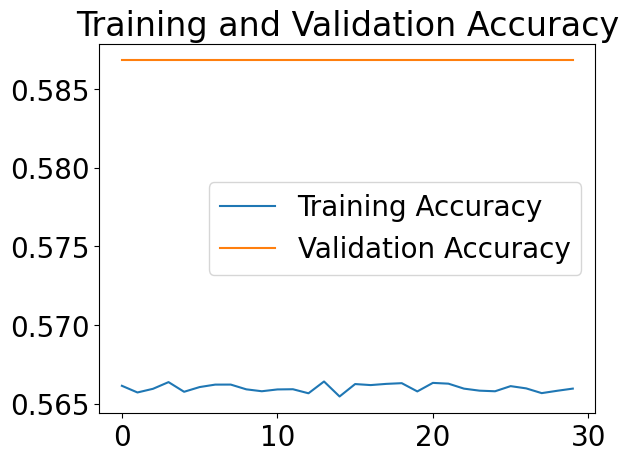

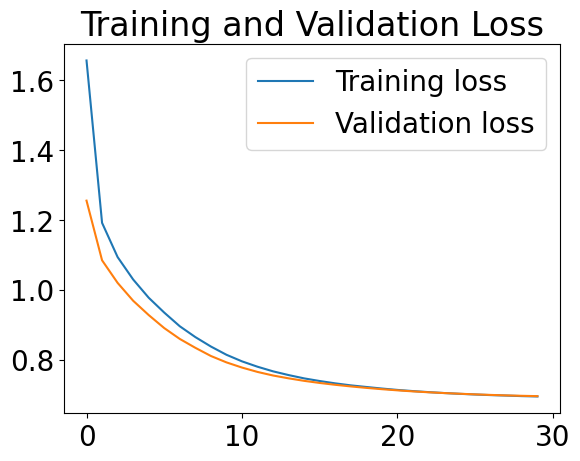

In [37]:
#summarize accuracy & loss

acc = RNN1.history['accuracy']
val_acc = RNN1.history['val_accuracy']

loss = RNN1.history['loss']
val_loss = RNN1.history['val_loss']
epochs = range(len(acc))


plt.rc('font', size=20)
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Model 2

In this iteration, the accuracy performance demonstrated evidence of overfitting around epoch 7, with the increase in validation loss. I try to reduce the learning rate to see if I can stabilize performance in the next model iteration.

In [38]:
with tpu_strategy.scope():
  model2 = Sequential([
    #The first layer = encoder: converts the text to a sequence of token indices
    encoder,
    #embedding layer stores one vector per word. converts the sequences of word indices to sequences of trainable vectors
    #After training (on enough data), words with similar meanings often have similar vectors.
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=batch_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #Bidirectional propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #conversion the sequence to a single vector Dense layers do some final processing, and convert from this vector representation to a single logit as the classification output.
    Dense(64, activation='relu'),
    Dense(1)])

  model2.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy'])




In [39]:
#time to train the model
checkpoint_filepath2 = 'model2'
os.makedirs(parent_path+'/'+checkpoint_filepath1,exist_ok = True)
#Saves the model's weights at specified intervals during training.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath2, save_weights_only=False, save_best_only=True)
RNN_callbacks = [model_checkpoint, early_stop, reduce_lr]

RNN2 = model2.fit(dis_tr_ds,
                  epochs=10,
                  callbacks = RNN_callbacks,
                  validation_data=dis_val_ds)

Epoch 1/10
96/96 [==============================] - 53s 433ms/step - loss: 1.3450 - binary_crossentropy: 1.3450 - accuracy: 0.5662 - val_loss: 0.9427 - val_binary_crossentropy: 0.9427 - val_accuracy: 0.5870 - lr: 1.0000e-04
Epoch 2/10
96/96 [==============================] - 37s 387ms/step - loss: 0.8312 - binary_crossentropy: 0.8312 - accuracy: 0.5662 - val_loss: 0.7084 - val_binary_crossentropy: 0.7084 - val_accuracy: 0.5870 - lr: 1.0000e-04
Epoch 3/10
96/96 [==============================] - 37s 389ms/step - loss: 0.6780 - binary_crossentropy: 0.6780 - accuracy: 0.5737 - val_loss: 0.6660 - val_binary_crossentropy: 0.6660 - val_accuracy: 0.5772 - lr: 1.0000e-04
Epoch 4/10
96/96 [==============================] - 35s 363ms/step - loss: 0.6454 - binary_crossentropy: 0.6454 - accuracy: 0.6074 - val_loss: 0.6494 - val_binary_crossentropy: 0.6494 - val_accuracy: 0.6067 - lr: 1.0000e-04
Epoch 5/10
96/96 [==============================] - 37s 386ms/step - loss: 0.6170 - binary_crossentropy:

In [40]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          1310464   
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1384833 (5.28 MB)
Trainable params: 1384

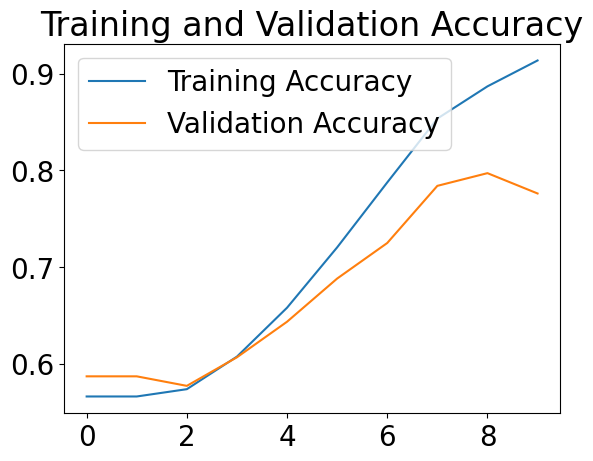

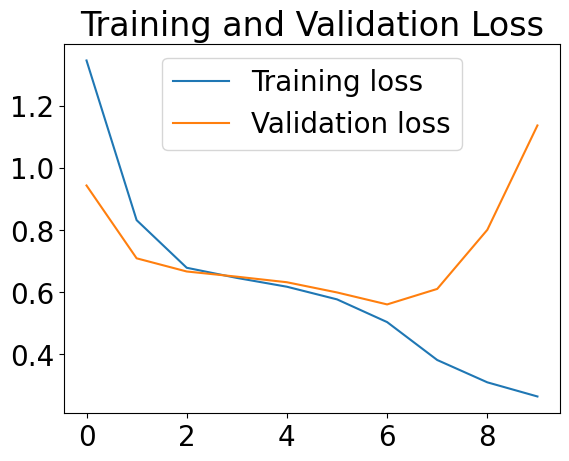

In [41]:
#summarize accuracy & loss

acc = RNN2.history['accuracy']
val_acc = RNN2.history['val_accuracy']

loss = RNN2.history['loss']
val_loss = RNN2.history['val_loss']
epochs = range(len(acc))


plt.rc('font', size=20)
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Model 3

Here we are starting to see more favorable accuracy behavior but still have evidence of overfitting in the validation loss performance. Lets add some regularization techniques to see if that improves the performance.

In [42]:
with tpu_strategy.scope():
  model3 = Sequential([
    #The first layer = encoder: converts the text to a sequence of token indices
    encoder,
    #embedding layer stores one vector per word. converts the sequences of word indices to sequences of trainable vectors
    #After training (on enough data), words with similar meanings often have similar vectors.
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=batch_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #Bidirectional propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #conversion the sequence to a single vector Dense layers do some final processing, and convert from this vector representation to a single logit as the classification output.
    Dense(64, activation='relu'),
    Dense(1)])

  model3.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.000075),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy'])




In [43]:
#time to train the model
checkpoint_filepath3 = 'model3'
os.makedirs(parent_path+'/'+checkpoint_filepath3,exist_ok = True)
#Saves the model's weights at specified intervals during training.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath3, save_weights_only=False, save_best_only=True)
RNN_callbacks = [model_checkpoint, early_stop, reduce_lr]

RNN3 = model3.fit(dis_tr_ds,
                  epochs=20,
                  callbacks = RNN_callbacks,
                  validation_data=dis_val_ds)

Epoch 1/20
96/96 [==============================] - 52s 427ms/step - loss: 1.1670 - binary_crossentropy: 1.1670 - accuracy: 0.5662 - val_loss: 0.8488 - val_binary_crossentropy: 0.8488 - val_accuracy: 0.5870 - lr: 7.5000e-05
Epoch 2/20
96/96 [==============================] - 39s 405ms/step - loss: 0.7633 - binary_crossentropy: 0.7633 - accuracy: 0.5652 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917 - val_accuracy: 0.5811 - lr: 7.5000e-05
Epoch 3/20
96/96 [==============================] - 38s 397ms/step - loss: 0.6820 - binary_crossentropy: 0.6820 - accuracy: 0.5608 - val_loss: 0.6772 - val_binary_crossentropy: 0.6772 - val_accuracy: 0.5798 - lr: 7.5000e-05
Epoch 4/20
96/96 [==============================] - 36s 380ms/step - loss: 0.6627 - binary_crossentropy: 0.6627 - accuracy: 0.5824 - val_loss: 0.6639 - val_binary_crossentropy: 0.6639 - val_accuracy: 0.5923 - lr: 7.5000e-05
Epoch 5/20
96/96 [==============================] - 39s 405ms/step - loss: 0.6429 - binary_crossentropy:

In [44]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          1310464   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1384833 (5.28 MB)
Trainable params: 1384

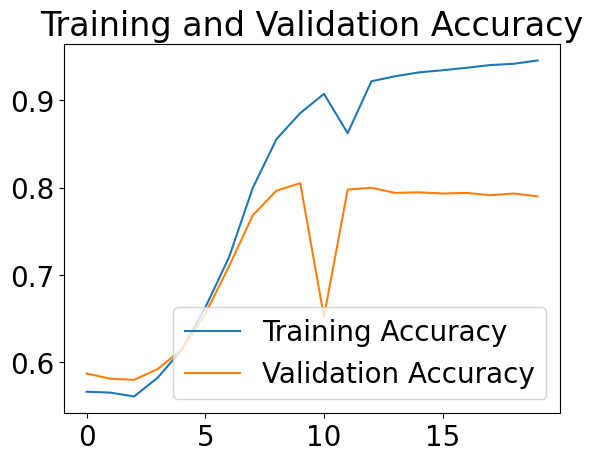

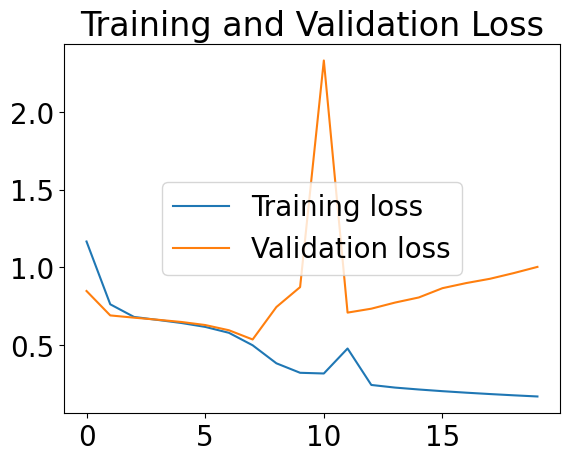

In [45]:
#summarize accuracy & loss

acc = RNN3.history['accuracy']
val_acc = RNN3.history['val_accuracy']

loss = RNN3.history['loss']
val_loss = RNN3.history['val_loss']
epochs = range(len(acc))


plt.rc('font', size=20)
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Model 4

Gradient clipping (both value and norm) did not do much to improve loss performance. Tried implementing Dropout regularization, which also did not improve loss performance. Finally, tried out L2 regularization which seemed to stabilize loss and accuracy performance. Given that this was the best performing model, I also decided to show the confusion matrix to see where there model was struggling to correctly make predictions. It looks like the incorrectly labelled tweets have pretty even distribution between the two classes. There isn't much evidence to suggest any particular bias and likely just means the model can use more tweaking to increase accuracy. Additionally, I calculated the F1 score, since that is what the competition would be evaluating the predictions on. It yielded a F1 score of 76.35, and actually did better on submission with a score of 79.04.

In [46]:
with tpu_strategy.scope():
  model4 = Sequential([
    #The first layer = encoder: converts the text to a sequence of token indices
    encoder,
    #embedding layer stores one vector per word. converts the sequences of word indices to sequences of trainable vectors
    #After training (on enough data), words with similar meanings often have similar vectors.
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=batch_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #Bidirectional propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
    #conversion the sequence to a single vector Dense layers do some final processing, and convert from this vector representation to a single logit as the classification output.
    Dense(64, activation='relu'),
    Dense(1)])

  model4.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.000075,
            clipnorm= 1.0),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy'])




In [47]:
#time to train the model
checkpoint_filepath4 = 'model4'
os.makedirs(parent_path+'/'+checkpoint_filepath4,exist_ok = True)
#Saves the model's weights at specified intervals during training.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath4, save_weights_only=False, save_best_only=True)
RNN_callbacks = [model_checkpoint, early_stop, reduce_lr]

RNN4 = model4.fit(dis_tr_ds,
                  epochs=20,
                  callbacks = RNN_callbacks,
                  validation_data=dis_val_ds)

Epoch 1/20
96/96 [==============================] - 52s 424ms/step - loss: 4.1867 - binary_crossentropy: 1.0833 - accuracy: 0.5662 - val_loss: 3.6256 - val_binary_crossentropy: 0.7388 - val_accuracy: 0.5870 - lr: 7.5000e-05
Epoch 2/20
96/96 [==============================] - 40s 417ms/step - loss: 3.3857 - binary_crossentropy: 0.6942 - accuracy: 0.5696 - val_loss: 3.1662 - val_binary_crossentropy: 0.6716 - val_accuracy: 0.5752 - lr: 7.5000e-05
Epoch 3/20
96/96 [==============================] - 37s 385ms/step - loss: 2.9877 - binary_crossentropy: 0.6681 - accuracy: 0.5711 - val_loss: 2.8115 - val_binary_crossentropy: 0.6642 - val_accuracy: 0.5883 - lr: 7.5000e-05
Epoch 4/20
96/96 [==============================] - 36s 379ms/step - loss: 2.6538 - binary_crossentropy: 0.6578 - accuracy: 0.5898 - val_loss: 2.5025 - val_binary_crossentropy: 0.6561 - val_accuracy: 0.6060 - lr: 7.5000e-05
Epoch 5/20
96/96 [==============================] - 38s 400ms/step - loss: 2.3628 - binary_crossentropy:

In [48]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          1310464   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1384833 (5.28 MB)
Trainable params: 1384

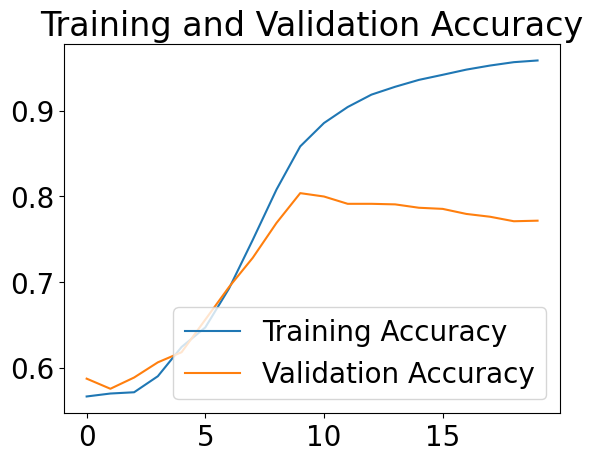

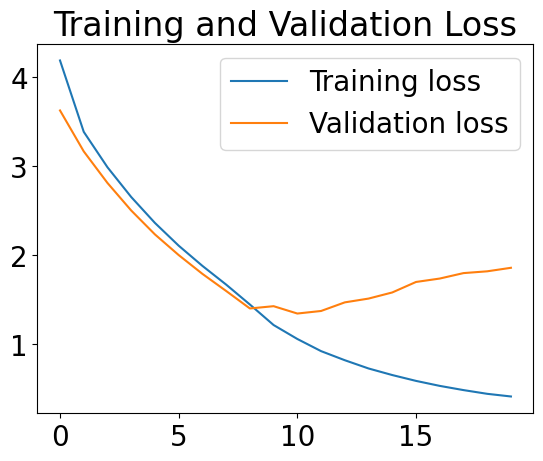

In [49]:

 #summarize accuracy & loss

acc = RNN4.history['accuracy']
val_acc = RNN4.history['val_accuracy']

loss = RNN4.history['loss']
val_loss = RNN4.history['val_loss']
epochs = range(len(acc))


plt.rc('font', size=20)
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

48/48 [==============================] - 5s 11ms/step


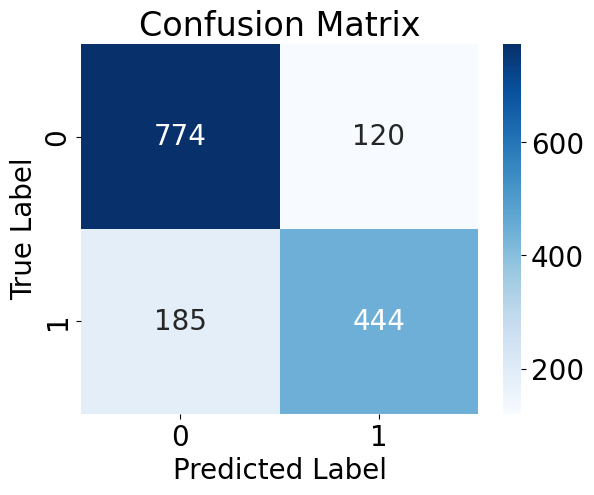

In [50]:
RNN4 = tf.keras.models.load_model(parent_path+'/'+checkpoint_filepath4)
y_pred = RNN4.predict(dis_val['text'])
y_true = dis_val['target']
y_pred_labels = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_true, y_pred_labels)
# print("Confusion Matrix:")
# print(conf_matrix)



sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [51]:
f1 = f1_score(y_true, y_pred_labels)

print(f"F1 Score: {f1}")

F1 Score: 0.7443419949706621


## Model 5
For additional experimentation, I tried out different values for the L2 regularization to see if performance further improves. 0.1 yielded exorbitant loss values and 0.001 led to overfitting. This hyperparameter was optimized at 0.01 in the previous model.

In [53]:
with tpu_strategy.scope():
  model5 = Sequential([
    #The first layer = encoder: converts the text to a sequence of token indices
    encoder,
    #embedding layer stores one vector per word. converts the sequences of word indices to sequences of trainable vectors
    #After training (on enough data), words with similar meanings often have similar vectors.
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=batch_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #Bidirectional propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001))),
    #conversion the sequence to a single vector Dense layers do some final processing, and convert from this vector representation to a single logit as the classification output.
    Dense(64, activation='relu'),
    Dense(1)])

  model5.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.000075,
            clipnorm= 1.0),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy'])




In [54]:
#time to train the model
checkpoint_filepath5 = 'model5'
os.makedirs(parent_path+'/'+checkpoint_filepath5,exist_ok = True)
#Saves the model's weights at specified intervals during training.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath5, save_weights_only=False, save_best_only=True)
RNN_callbacks = [model_checkpoint, early_stop, reduce_lr]

RNN5 = model5.fit(dis_tr_ds,
                  epochs=20,
                  callbacks = RNN_callbacks,
                  validation_data=dis_val_ds)

Epoch 1/20
96/96 [==============================] - 53s 428ms/step - loss: 1.8144 - binary_crossentropy: 1.4978 - accuracy: 0.5662 - val_loss: 1.1130 - val_binary_crossentropy: 0.8155 - val_accuracy: 0.5870 - lr: 7.5000e-05
Epoch 2/20
96/96 [==============================] - 33s 347ms/step - loss: 1.0086 - binary_crossentropy: 0.7277 - accuracy: 0.5670 - val_loss: 0.9366 - val_binary_crossentropy: 0.6723 - val_accuracy: 0.5936 - lr: 7.5000e-05
Epoch 3/20
96/96 [==============================] - 38s 399ms/step - loss: 0.9182 - binary_crossentropy: 0.6686 - accuracy: 0.5754 - val_loss: 0.9000 - val_binary_crossentropy: 0.6650 - val_accuracy: 0.5942 - lr: 7.5000e-05
Epoch 4/20
96/96 [==============================] - 36s 381ms/step - loss: 0.8795 - binary_crossentropy: 0.6570 - accuracy: 0.5954 - val_loss: 0.8663 - val_binary_crossentropy: 0.6562 - val_accuracy: 0.6126 - lr: 7.5000e-05
Epoch 5/20
96/96 [==============================] - 39s 404ms/step - loss: 0.8433 - binary_crossentropy:

In [55]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, None, 64)          1310464   
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1384833 (5.28 MB)
Trainable params: 1384

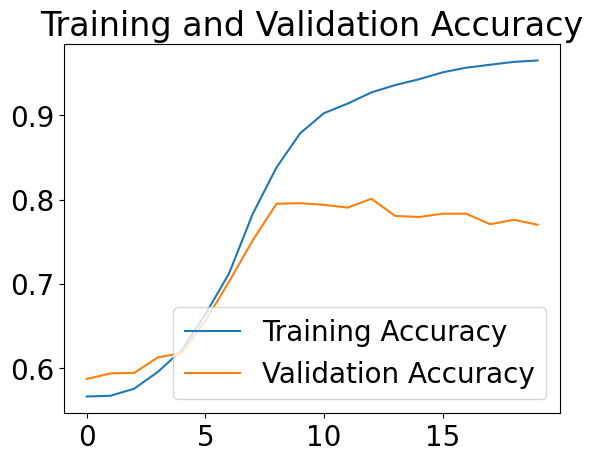

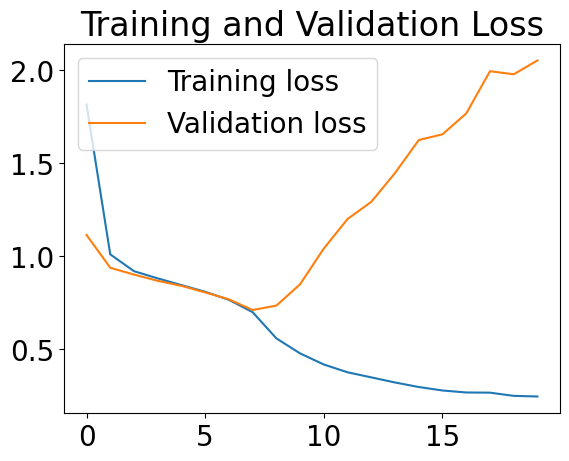

In [56]:

 #summarize accuracy & loss

acc = RNN5.history['accuracy']
val_acc = RNN5.history['val_accuracy']

loss = RNN5.history['loss']
val_loss = RNN5.history['val_loss']
epochs = range(len(acc))


plt.rc('font', size=20)
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Model 6

Additionally, I tried out different architechture to include 2 LTSM layers to see if that would improve performance. The accuracy and loss functions look pretty decent, but the additional LSTM layer did cause the training time to run nearly 2x as long.

In [57]:
with tpu_strategy.scope():
  model6 = Sequential([
    #The first layer = encoder: converts the text to a sequence of token indices
    encoder,
    #embedding layer stores one vector per word. converts the sequences of word indices to sequences of trainable vectors
    #After training (on enough data), words with similar meanings often have similar vectors.
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=batch_size,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #Bidirectional propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
    #conversion the sequence to a single vector Dense layers do some final processing, and convert from this vector representation to a single logit as the classification output.
    Dense(64, activation='relu'),
    Dense(1)])

  model6.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.000075,
            clipnorm= 1.0),
        loss = 'BinaryCrossentropy',
        metrics = ['BinaryCrossentropy','accuracy'])




In [58]:
#time to train the model
checkpoint_filepath6 = 'model6'
os.makedirs(parent_path+'/'+checkpoint_filepath6,exist_ok = True)
#Saves the model's weights at specified intervals during training.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath6, save_weights_only=False, save_best_only=True)
RNN_callbacks = [model_checkpoint, early_stop, reduce_lr]

RNN6 = model6.fit(dis_tr_ds,
                  epochs=20,
                  callbacks = RNN_callbacks,
                  validation_data=dis_val_ds)

Epoch 1/20
96/96 [==============================] - 94s 712ms/step - loss: 12.7434 - binary_crossentropy: 6.6917 - accuracy: 0.5662 - val_loss: 11.9584 - val_binary_crossentropy: 6.3705 - val_accuracy: 0.5870 - lr: 7.5000e-05
Epoch 2/20
96/96 [==============================] - 69s 722ms/step - loss: 11.8769 - binary_crossentropy: 6.6917 - accuracy: 0.5662 - val_loss: 11.1581 - val_binary_crossentropy: 6.3705 - val_accuracy: 0.5870 - lr: 7.5000e-05
Epoch 3/20
96/96 [==============================] - 69s 724ms/step - loss: 11.1331 - binary_crossentropy: 6.6917 - accuracy: 0.5662 - val_loss: 10.4698 - val_binary_crossentropy: 6.3705 - val_accuracy: 0.5870 - lr: 7.5000e-05
Epoch 4/20
96/96 [==============================] - 68s 717ms/step - loss: 10.4927 - binary_crossentropy: 6.6917 - accuracy: 0.5662 - val_loss: 9.8764 - val_binary_crossentropy: 6.3705 - val_accuracy: 0.5870 - lr: 7.5000e-05
Epoch 5/20
96/96 [==============================] - 60s 632ms/step - loss: 10.1706 - binary_cross

In [59]:
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_6 (Embedding)     (None, None, 64)          1310464   
                                                                 
 bidirectional_5 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                      

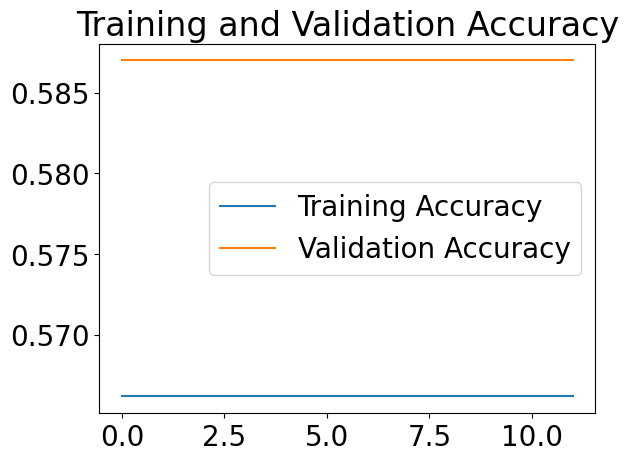

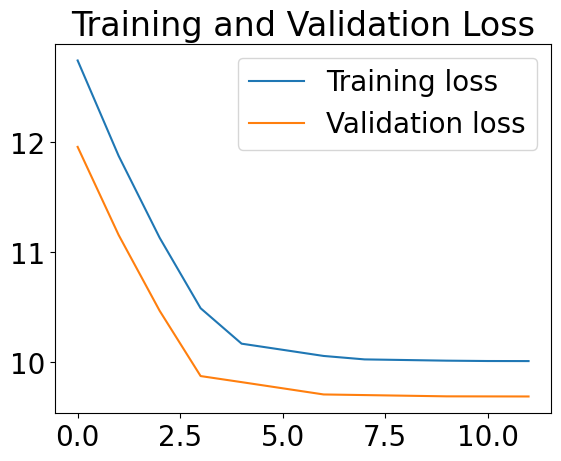

In [60]:

 #summarize accuracy & loss

acc = RNN6.history['accuracy']
val_acc = RNN6.history['val_accuracy']

loss = RNN6.history['loss']
val_loss = RNN6.history['val_loss']
epochs = range(len(acc))


plt.rc('font', size=20)
plt.plot(epochs, acc, label = "Training Accuracy"),
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label = "Training loss"),
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Set up submission data

In [61]:
dis_test = pd.read_csv(test_path)

In [62]:
checkpoint_filepath1 = 'model1'
checkpoint_filepath2 = 'model2'
checkpoint_filepath3 = 'model3'
checkpoint_filepath4 = 'model4'
checkpoint_filepath5 = 'model5'
checkpoint_filepath6 = 'model6'

In [63]:
#create tf dataset of testing data
dis_test_work = dis_test.drop(['keyword','location', 'id'], axis = 1)
dis_test_ds = tf.data.Dataset.from_tensor_slices(dis_test_work.text.values).batch(batch_size).prefetch(AUTOTUNE)


#load saved models
with tpu_strategy.scope():
    #model1 = tf.keras.models.load_model(parent_path+'/'+checkpoint_filepath1)
    model2 = tf.keras.models.load_model(parent_path+'/'+checkpoint_filepath2)
    model3 = tf.keras.models.load_model(parent_path+'/'+checkpoint_filepath3)
    model4 = tf.keras.models.load_model(parent_path+'/'+checkpoint_filepath4)
    model5 = tf.keras.models.load_model(parent_path+'/'+checkpoint_filepath5)
    model6 = tf.keras.models.load_model(parent_path+'/'+checkpoint_filepath6)

#make predictions
#pred1_raw = model1.predict(dis_test_ds)
pred2_raw = model2.predict(dis_test_ds)
pred3_raw = model3.predict(dis_test_ds)
pred4_raw = model4.predict(dis_test_ds)
pred5_raw = model5.predict(dis_test_ds)
pred6_raw = model6.predict(dis_test_ds)
#convert logits to classification output
#pred1 = (pred1_raw.to_tensor().numpy()> 0.5).astype(int)
pred2 = (pred2_raw> 0.5).astype(int)
pred3 = (pred3_raw> 0.5).astype(int)
pred4 = (pred4_raw> 0.5).astype(int)
pred5 = (pred5_raw> 0.5).astype(int)
pred6 = (pred6_raw> 0.5).astype(int)
# create submission dataframes
dis_test_sub = dis_test.copy()
dis_test_sub = dis_test_sub.drop(['keyword','location','text'], axis = 1)

# pred1_df = dis_test.copy()
# pred1_df['label'] = pred1
pred2_df = dis_test_sub.copy()
pred2_df['target'] = pred2

pred3_df = dis_test_sub.copy()
pred3_df['target'] = pred3

pred4_df = dis_test_sub.copy()
pred4_df['target'] = pred4

pred5_df = dis_test_sub.copy()
pred5_df['target'] = pred5

pred6_df = dis_test_sub.copy()
pred6_df['target'] = pred6

#preview dataframes
#print("mod1 predictions preview", pred1_df.head(5))
print("mod2 predictions preview")
display(pred2_df.head(5))
print("mod3 predictions preview")
display(pred3_df.head(5))
print("mod4 predictions preview")
display(pred4_df.head(5))
print("mod5 predictions preview")
display(pred5_df.head(5))
print("mod6 predictions preview")
display(pred6_df.head(5))

#export to submission csv's
#pred1_df.to_csv(parent_path+'/Model1_submission.csv',index=False)
pred2_df.to_csv(parent_path+'/Model2_submission.csv',index=False)
pred3_df.to_csv(parent_path+'/Model3_submission.csv',index=False)
pred4_df.to_csv(parent_path+'/Model4_submission.csv',index=False)
pred5_df.to_csv(parent_path+'/Model5_submission.csv',index=False)
pred6_df.to_csv(parent_path+'/Model6_submission.csv',index=False)

51/51 [==============================] - 8s 24ms/step
mod2 predictions preview


,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


mod3 predictions preview


,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


mod4 predictions preview


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


mod5 predictions preview


,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


mod6 predictions preview


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## Results



In [65]:
model_sum = pd.DataFrame({
 'Architecture':['Model 1 Vanilla RNN','Model 1 Vanilla RNN','Model 1 Vanilla RNN','Model 2 LSTM RNN',
                 'Model 2 LSTM RNN','Model 2 LSTM RNN','Model 2 LSTM RNN', 'Model 2 LSTM RNN',
                 'Model 3 LSTM RNN','Model 3 LSTM RNN','Model 3 LSTM RNN','Model 3 LSTM RNN',
                 'Model 3 LSTM RNN','Model 3 LSTM RNN','Model 3 LSTM RNN', 'Model 3 LSTM RNN',
                 'Model 4 LSTM RNN', 'Model 5 LSTM RNN', 'Model 6 stacked LSTM RNN'],
 'Learning Rate':[.0001,.00001,.0001,.0001,
                  .00001,.00005,.00005,.000075,
                  .000075,.000075,.000075,.000075,
                  .000075,.000075,.000075,.000075,
                  .000075,.000075,.000075,],
 'Bidirectional Layers':['N','N','N','Y',
             'Y','Y','Y','Y',
             'Y','Y','Y','Y',
             'Y','Y','Y','Y',
              'Y','Y','Y',],
 'Optimizer':['Adam','Adam','Adam','Adam',
              'Adam','Adam','Adam','Adam',
              'Adam','Adam','Adam','Adam',
              'Adam','Adam','Adam','Adam',
              'Adam','Adam','Adam'],
 'Epochs':[10,10,30,10,
           10,10,20,20,
           20,20,20,20,
           20,20,20,20,
           20,20,20],
'Regularization':['n/a','n/a','n/a','n/a',
                  'n/a','n/a','n/a','n/a',
                  'Clip val','Clip val','Clip val', 'Clip Norm',
                  'Dropout','Dropout', 'Dropout', 'Dropout & recurrent',
                  'L2 & recurrent','L2 & recurrent', 'L2 & recurrent'],

 'Regularization value': ['n/a','n/a','n/a','n/a',
                    'n/a','n/a','n/a','n/a',
                    0.5,0.05,0.75, 1,
                    0.2,0.02, 0.5, 0.5,
                    0.1,0.001, 0.01],

 "Public LB":['Gradient Runaway','Not Scored','Not Scored','Not Scored',
                'Not Scored','Not Scored', 'Not Scored', 70.79,
                'Not Scored' , 'Not Scored', 'Not Scored' , 'Not Scored' ,
                'Not Scored' ,'Not Scored', 'Not Scored', 72.30,
                77.97, 72.30, 57.03
          ],

 "Rank":[None,None,None,None,
         None,None,None,3,
         None,None,None,None,
         None,None,None,2,
         1,2,4]

 })

model_sum

,Architecture,Learning Rate,Bidirectional Layers,Optimizer,Epochs,Regularization,Regularization value,Public LB,Rank
0,Model 1 Vanilla RNN,0.000100,N,Adam,10,n/a,n/a,Gradient Runaway,NaN
1,Model 1 Vanilla RNN,0.000010,N,Adam,10,n/a,n/a,Not Scored,NaN
2,Model 1 Vanilla RNN,0.000100,N,Adam,30,n/a,n/a,Not Scored,NaN
3,Model 2 LSTM RNN,0.000100,Y,Adam,10,n/a,n/a,Not Scored,NaN
4,Model 2 LSTM RNN,0.000010,Y,Adam,10,n/a,n/a,Not Scored,NaN
5,Model 2 LSTM RNN,0.000050,Y,Adam,10,n/a,n/a,Not Scored,NaN
6,Model 2 LSTM RNN,0.000050,Y,Adam,20,n/a,n/a,Not Scored,NaN
7,Model 2 LSTM RNN,0.000075,Y,Adam,20,n/a,n/a,70.79,3.0
8,Model 3 LSTM RNN,0.000075,Y,Adam,20,Clip val,0.5,Not Scored,NaN
9,Model 3 LSTM RNN,0.000075,Y,Adam,20,Clip val,0.05,Not Scored,NaN


## Conclusion

In this project, we tackled classifying whether tweets from twitter were about natural disasters or not. We utilized a Recurrent Neural Network(RNN) model to train to existing labelled tweets. Hyperparameters taken into consideration for optimization included learning rate, the inclusion of a bidirectional layer, optimizer, # of epochs for training, utilization of regularization. Given that this was a binary classification problem, I settled with binary cross entropy as the loss function to be monitored. After some researching, I went with ADAM optimizer for initial model implementation. For the purpose of this project, it provided adequate performance that I continued to use it for all iterations going forward. However, in the future I would like to try out different optimizers to see if performance can be improved, included NADAM, SGE, RMSprop.

Picking an appropriate learning rate was also important since with certain iterations that performance metrics would either converge too early and lead to noisy graphs or would take a very long time to converge, sucking up computing resources. Very much a goldilocks situations of finding just the right sweet spot. In a similar vain, experimenting with the number of epochs was also a balance between giving the model enough time to pick up on patterns but also ensuring it didn't train for too long to the point of overfitting.

For model architecture, I kept iterations pretty simple. The initial implementation utilized a vanilla RNN architecture without any LSTM layers. This model showed no real sign of accuracy improvement during training, despite loss performance indicating desirable behavior. I learned this means that the model performs consistently but inaccuractely. Next implementation utilized 1 LSTM layer, from here performance started to improve incrementally. To further confirm the sweet spot, I also implemented stacked LSTM layer with 2 in the finaly model trained. Here I was shown the results of overcomplicating architecture because the model took almost 2x as long to train and performed slightly worse in the competition.

With the final submission score of 77.97, there is still room for improvement to be made in this model. In the future I'd like to try out different optimizers, architectures, and activiation functions for the dense layers.

Thank you for taking time to look at my notebook.

Reference list
* [Text Classification Rnn](https://www.tensorflow.org/text/tutorials/text_classification_rnn)
*[TextVectorization Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)